# Periodic Table of Uiua

I am having trouble styling the glyphs to match the site. I actually think we
might be able to do better. Currently the coloring encodes the type of function
(ie Modifier/Stack etc) and some information about number of input arguments.

From my inspection so far I don't see that the coloring encodes number of output
arguments. I don't think its possible to encode everything in colour and layout
alone. But with a periodic table thing... maybe?

## Match Uiua Website

The first thing is to try match the uiua web editor colors, then we can try get fancy later.

In [1]:
import pandas as pd
import json
from pathlib import Path
from typing import Optional

In [2]:
import re
def strip_js(js_text:str)->str:
    """keep everything between the first `[` and last `]` inclusive"""
    result = re.search(
        pattern = r"\[.*\]",
        string  = js_text,
        flags   = re.DOTALL
    )
    return result.group(0) if result else ""

def read_js_json(file_path:str):
    return json.loads(strip_js(
        Path(file_path).read_text()
    ))

In [3]:
df = pd.DataFrame.from_records(
    [
        *read_js_json("./webview_keypad/primitives.js"),
        *read_js_json("./webview_keypad/extra_primitives.js"),
    ]
)
df

,name,description,glyph,count_inputs,count_outputs,count_modifier_inputs,primitive_class,docs
0,duplicate,Duplicate the top value on the stack,.,1.0,2.0,NaN,Stack,NaN
1,over,Duplicate the second-to-top value to the top o...,",",2.0,3.0,NaN,Stack,NaN
2,flip,Swap the top two values on the stack,∶,2.0,2.0,NaN,Stack,NaN
3,pop,Discard the top stack value,;,1.0,0.0,NaN,Stack,NaN
4,identity,Do nothing,∘,1.0,1.0,NaN,Planet,NaN
...,...,...,...,...,...,...,...,...
165,string,,"""",NaN,NaN,NaN,Syntax,types#characters
166,placeholder,,^,NaN,NaN,NaN,Syntax,custommodifiers
167,binding,Gives a global name a value,←,NaN,NaN,NaN,Syntax,bindings
168,signature / terminator,,|,NaN,NaN,NaN,Syntax,functions#stack-signatures


In [4]:
# gdf = df[df["glyph"].notna()]
# print("\n".join("^wewah "+ gdf["name"] + ": \"" + gdf["glyph"]+"\""))

In [5]:
df['primitive_class'].unique()

array(['Stack', 'Planet', 'MonadicPervasive', 'DyadicPervasive',
       'MonadicArray', 'DyadicArray', 'AggregatingModifier',
       'IteratingModifier', 'OtherModifier', 'Ocean', 'Control', 'Misc',
       'Constant', 'Sys(StdIO)', 'Sys(Env)', 'Sys(Command)',
       'Sys(Filesystem)', 'Sys(Misc)', 'Sys(Stream)', 'Sys(Images)',
       'Sys(Gifs)', 'Sys(Audio)', 'Sys(Tcp)', 'Syntax'], dtype=object)

In [117]:
existing_map = {
    "stack-function"   : "#d1daec",
    "noadic-function"  : "#ed5e6a",
    "monadic-function" : "#95d16a",
    "dyadic-function"  : "#54b0fc",
    "monadic-modifier" : "#f0c36f",
    "dyadic-modifier"  : "#cc6be9",
    "ocean-function"   : "#03d7d9",
}
new_map = {
    'Stack'                : existing_map["stack-function"],
    'Planet'               : existing_map["monadic-modifier"],
    'MonadicPervasive'     : existing_map["monadic-function"],
    'MonadicArray'         : existing_map["monadic-function"],
    'DyadicPervasive'      : existing_map["dyadic-function"],
    'DyadicArray'          : existing_map["dyadic-function"],
    'AggregatingModifier'  : existing_map["monadic-modifier"],
    'IteratingModifier'    : existing_map["monadic-modifier"],
    'OtherModifier'        : existing_map["monadic-modifier"],
    'Ocean'                : existing_map["ocean-function"],
    'Control'              : existing_map["dyadic-modifier"],
    'Misc'                 : "goldenrod",
    'Constant'             : "brown",
    'Sys'                  : "palegreen",
    'Syntax'               : "#888",
}
df["color_foreground"] = df["primitive_class"].map(new_map)
df["pervasive"] = df["primitive_class"].str.contains("Pervasive").map({True:"∀", False:""})
df["modifier"] = (
      df["primitive_class"].str.contains("Modifier")
    | (df["count_modifier_inputs"]>0)

).map({True:"M", False:""}) 

In [118]:
len(";".join(df.loc[df["glyph"].isna(), "description"].iloc[25:]))

1084

In [119]:
# we just shortened the descriptions for glyph-less functions
# since only they will show up in the periodic table
# manually 
shortened_descriptions = {
    "spawn"    : "thread spawn",
    "wait"     : "thread join",
    "gen"      : "rand gen",
    "deal"     : "array shuffle",
    "parse"    : "str to num",
    "regex"    : "match",
    "utf"      : "str to utf8",
    "tag"      : "gen unique",
    "type"     : "array type",
    "now"      : "time get",
    "dump"     : "debug print",
    "&s"       : "pretty print",
    "&pf"      : "print",
    "&p"       : "print newline",
    "&sc"      : "read line",
    "&ts"      : "terminal size",
    "&args"    : "cmd args",
    "&var"     : "env var",
    "&runi"    : "cmd run",
    "&runc"    : "cmd run",
    "&cd"      : "dir change",
    "&sl"      : "sleep",
    "&rs"      : "strm read",
    "&rb"      : "strm read",
    "&ru"      : "strm rd delim",
    "&w"       : "strm write",
    "&cl"      : "strm close",
    "&i"       : "file import",
    "&invk"    : "os open",
    "&fo"      : "file open",
    "&fc"      : "file create",
    "&fe"      : "file exists",
    "&fld"     : "dir list",
    "&fif"     : "path check",
    "&fras"    : "file read",
    "&frab"    : "file rd bytes",
    "&fwa"     : "file write",
    "&imd"     : "img dec",
    "&ime"     : "img enc",
    "&ims"     : "img show",
    "&gife"    : "gif encode",
    "&gifs"    : "gif show",
    "&ad"      : "aud dec",
    "&ae"      : "aud enc",
    "&ap"      : "aud play",
    "&asr"     : "aud smpl rate",
    "&ast"     : "aud synth",
    "&tcpl"    : "tcp listn",
    "&tcpa"    : "tcp accept",
    "&tcpc"    : "tcp con",
    "&tcpsnb"  : "tcp non-block",
    "&tcpsrt"  : "tcp rd tout",
    "&tcpswt"  : "tcp wt tout",
    "&tcpaddr" : "tcp addr",
    "&httpsw"  : "http req"
}
assert(all(item in df["name"].unique() for item in shortened_descriptions.keys()))
df["shortened_description"] = df["name"].map(shortened_descriptions)

In [8]:
df[df["count_outputs"].isna()]

,name,description,glyph,count_inputs,count_outputs,count_modifier_inputs,primitive_class,docs
160,array,,[],NaN,NaN,NaN,Syntax,arrays
161,box array,,{},NaN,NaN,NaN,Syntax,arrays#nested-arrays
162,function,,(),NaN,NaN,NaN,Syntax,functions#inline-functions
163,character,,@,NaN,NaN,NaN,Syntax,types#characters
164,fmt/multiline str,,$,NaN,NaN,NaN,Syntax,functions#format-strings
165,string,,"""",NaN,NaN,NaN,Syntax,types#characters
166,placeholder,,^,NaN,NaN,NaN,Syntax,custommodifiers
167,binding,Gives a global name a value,←,NaN,NaN,NaN,Syntax,bindings
168,signature / terminator,,|,NaN,NaN,NaN,Syntax,functions#stack-signatures
169,comment,,#,NaN,NaN,NaN,Syntax,basic#comments


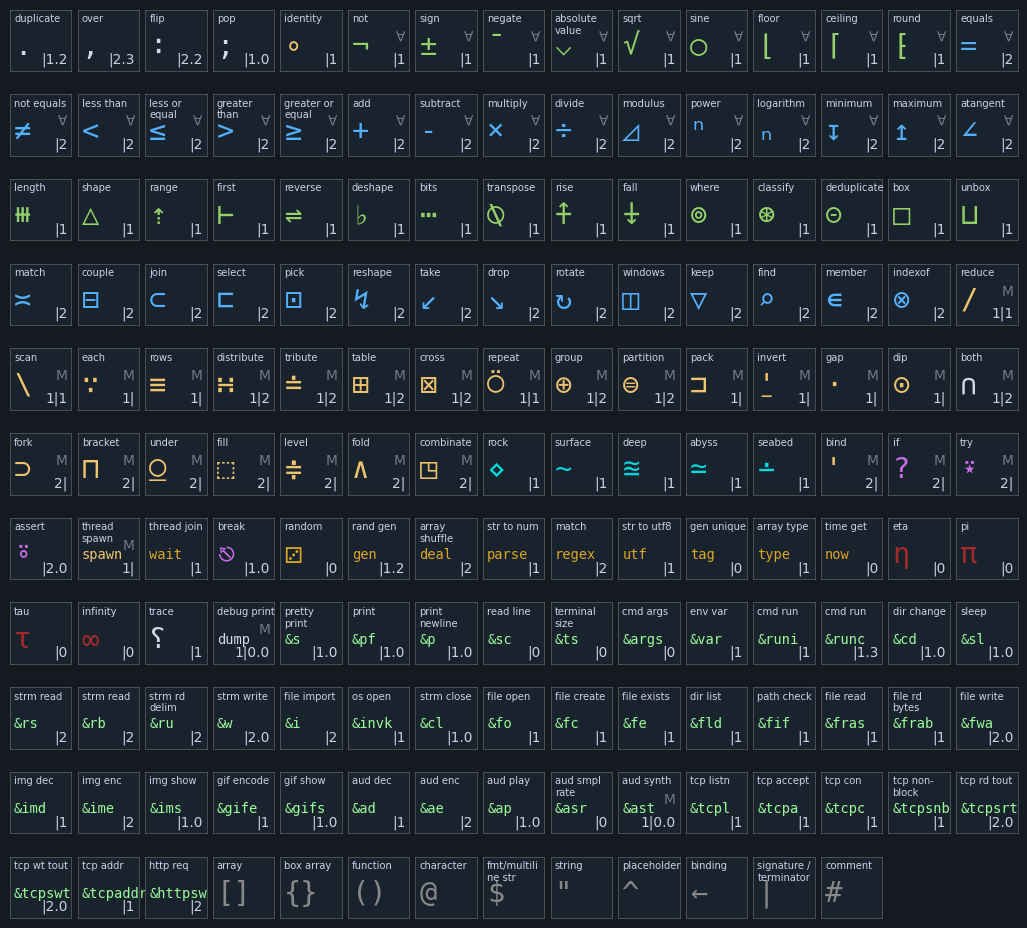

In [120]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager as fm
from matplotlib.axes import Axes
import matplotlib.gridspec as gridspec

import textwrap

font_properties = fm.FontProperties(family="DejaVu Sans Mono")

def signature(
        stack_input:Optional[int],
        stack_output:Optional[int],
        mod_input:Optional[int],
    ):
    def fillna(item):
        return item if pd.notna(item) else None
    match (fillna(mod_input), fillna(stack_input), fillna(stack_output)):
        case (None, int(i)|float(i), 1):
            return f"|{i:.0f}"
        case (None, int(i)|float(i), int(o)|float(o)):
            return f"|{i:.0f}.{o:.0f}"
        case (int(mi)|float(mi), None, 1):
            return f"{mi:.0f}|"
        case (int(mi)|float(mi), int(i)|float(i), 1):
            return f"{mi:.0f}|{i:.0f}"
        case (int(mi)|float(mi), int(i)|float(i), int(o)|float(o)):
            return f"{mi:.0f}|{i:.0f}.{o:.0f}"
        case (None, None, None):
            return ""
        case _:
            raise ValueError(f"Unexpected Signature ({mod_input}, {stack_input}, {stack_output})")

def draw_element(
        ax:Axes,
        size:float,
        padding:float,
        font_scale:float,
        glyph:Optional[str],
        glyph_color:str,
        name:str,
        description:str,
        pervasive:str,
        modifier:str,
        stack_input:Optional[int],
        stack_output:Optional[int],
        mod_input:Optional[int],
        foreground_colour:str = "#c8d2e4",
        wrap_characters:int = 12,
    ):
    if glyph == "" or pd.isna(glyph) or glyph is None:
        # glyph-less primitive
        central_text = name
        central_text_size = 11
        info_text = description[:18]
    else:
        # glyph primitive
        central_text = glyph
        central_text_size = 23
        info_text = name
    
    central_glyph_text = ax.text(
        x = padding,
        y = size/5*3, 
        s = central_text,
        color=glyph_color,
        fontsize=central_text_size*font_scale,
        font_properties=font_properties,
        verticalalignment='center'
    )
    name_or_description_text = ax.text(
        x =  padding,
        y =  padding, 
        s = textwrap.fill(info_text, width=wrap_characters),
        color=foreground_colour,
        fontsize=8*font_scale,
        verticalalignment='top'
    )
    signature_text = ax.text(
        x = size-padding,
        y = size-padding, 
        s = signature(stack_input, stack_output, mod_input),
        color=foreground_colour,
        fontsize=11*font_scale,
        verticalalignment='bottom',
        horizontalalignment='right'
    )
    pervasive_indicator_text = ax.text(
        x = size-padding,
        y = size/3, 
        s = pervasive,
        color=foreground_colour,
        fontsize=11*font_scale,
        verticalalignment='top',
        horizontalalignment='right'
    )
    pervasive_indicator_text.set_alpha(0.5)
    modifier_indicator_text = ax.text(
        x = size-padding,
        y = size/3, 
        s = modifier,
        color=foreground_colour,
        fontsize=11*font_scale,
        verticalalignment='top',
        horizontalalignment='right'
    )
    modifier_indicator_text.set_alpha(0.5)

count_columns = 15
count_rows = len(df) // count_columns + 1
spacing = 5
padding = 50/15
size    = 50
foreground_colour = "#c8d2e4"
fig_background_colour = "#141a1f"
background_colour = "#19232d"
outline_colour    = "#606468"

# fig, axs = plt.subplots(ncols=columns, nrows= len(df)//columns + 1, figsize=(16, 12))
# axs = axs.flatten()

fig = plt.figure(figsize=(13, 12))
gs = gridspec.GridSpec(
    nrows         = count_rows,
    ncols         = count_columns,
    figure        = fig,
    width_ratios  = [1]*count_columns,
    height_ratios = [1]*count_rows,
    wspace        = spacing/size,
    hspace        = spacing/size
)
axs = [fig.add_subplot(gs[i]) for i in range(len(df))]

for ax in axs:
    ax.set(
        aspect      = 'equal',
        facecolor   = background_colour,
        xlim        = (0, size),
        ylim        = (0, size),
        xticks      = [],
        yticks      = [],
    )
    for spine in ax.spines.values():
        spine.set_edgecolor(outline_colour)
        spine.set_linewidth(0.5)
    ax.invert_yaxis()

fig.set_facecolor(fig_background_colour)

for index,(ax,(row_index, row)) in enumerate(zip(axs, df.iterrows())):
    
    x       = index  % count_columns * (size + spacing)
    y       = index // count_columns * (size + spacing)
    draw_element(
        ax,
        size              = size,
        padding           = padding,
        font_scale        = 0.90,
        glyph             = row['glyph'],
        glyph_color       = row['color_foreground'],
        name              = row['name'],
        description       = row['shortened_description'],
        pervasive         = row['pervasive'],
        modifier          = row['modifier'],
        stack_input       = row['count_inputs'],
        stack_output      = row['count_outputs'],
        mod_input         = row['count_modifier_inputs'],
        foreground_colour = foreground_colour,
        wrap_characters   = 11
    )


fig.savefig("test.svg")
plt.show()